In [67]:
# System imports
import os
import sys

# Import packages
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse
import seaborn as sns
import datetime
import matplotlib.dates as mdates

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from scipy.stats import levene
import scipy.stats as stats
from scipy.stats import f_oneway

import warnings

from pyhrv import time_domain
from pyhrv import frequency_domain
from pyhrv import nonlinear
from pyhrv import hrv
from pyhrv import tools


#from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values


In [37]:
# Load data
patient_info = pd.read_csv("hyperaktiv/patient_info.csv", sep=";")

patient_info.head()


,ID,SEX,AGE,ACC,ACC_TIME,ACC_DAYS,HRV,HRV_TIME,HRV_HOURS,CPT_II,...,HADS_D,MED,MED_Antidepr,MED_Moodstab,MED_Antipsych,MED_Anxiety_Benzo,MED_Sleep,MED_Analgesics_Opioids,MED_Stimulants,filter_$
0,1,0,3,1,16:00:00,6.0,1,11:00:00,21.0,0,...,2.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2,0,4,1,10:54:00,6.8,0,NaN,NaN,1,...,7.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3,1,2,1,15:28:00,7.2,1,15:25:00,21.0,1,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4,1,3,0,NaN,NaN,1,16:55:00,22.0,1,...,6.0,1,1.0,NaN,NaN,1.0,NaN,1.0,NaN,0
4,5,1,1,1,14:24:00,5.9,1,16:00:00,12.0,1,...,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [38]:
HRV_DF = patient_info[patient_info['HRV']==1]
HRV_DF = HRV_DF[["ID", "SEX", "AGE", "ADHD", "HRV", "HRV_TIME", "HRV_HOURS"]]
HRV_DF["HRV_TIME_delta"] = pd.to_timedelta(HRV_DF.HRV_TIME)
HRV_DF["HRV_TIME_float"] = HRV_DF["HRV_TIME_delta"] / pd.offsets.Hour(1)

print(HRV_DF)

      ID  SEX  AGE  ADHD  HRV  HRV_TIME  HRV_HOURS  HRV_TIME_delta  \
0      1    0    3     1    1  11:00:00       21.0 0 days 11:00:00   
2      3    1    2     1    1  15:25:00       21.0 0 days 15:25:00   
3      4    1    3     1    1  16:55:00       22.0 0 days 16:55:00   
4      5    1    1     1    1  16:00:00       12.0 0 days 16:00:00   
5      7    0    3     0    1  10:20:00       21.0 0 days 10:20:00   
..   ...  ...  ...   ...  ...       ...        ...             ...   
94    98    0    3     1    1  15:00:00       17.0 0 days 15:00:00   
97   101    1    1     0    1  14:30:00       21.0 0 days 14:30:00   
98   103    1    4     0    1  09:26:00       22.0 0 days 09:26:00   
99   104    0    2     0    1  12:00:00       22.0 0 days 12:00:00   
100  105    1    4     0    1  13:25:00       13.0 0 days 13:25:00   

     HRV_TIME_float  
0         11.000000  
2         15.416667  
3         16.916667  
4         16.000000  
5         10.333333  
..              ...  
94   

Plots 

- Age distribution
- Number of hours of HRV recordings
- Number of days of activity recordings


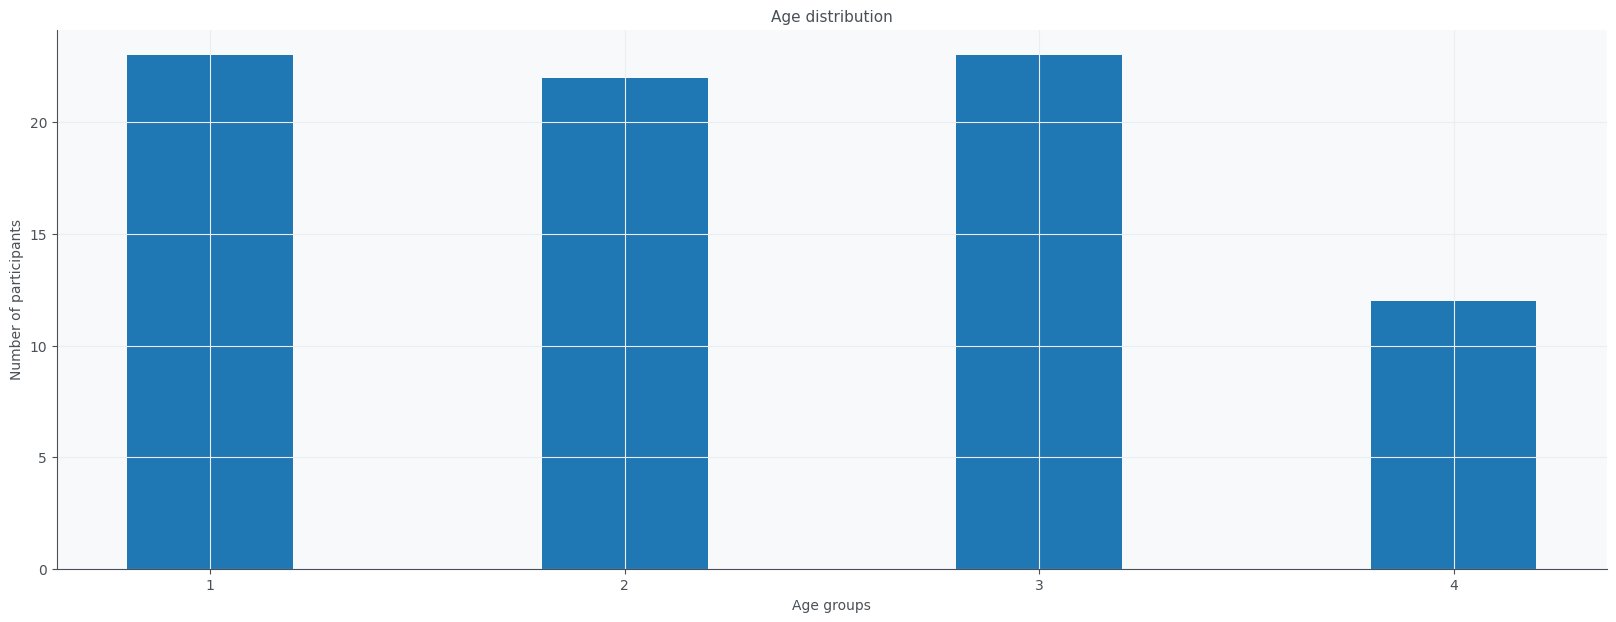

In [39]:
# Plot age distribution

plt.figure(figsize=(20,7))
plt.title("Age distribution")
plt.xlabel("Age groups")
plt.ylabel("Number of participants")

labels, counts = np.unique(HRV_DF.AGE, return_counts=True)
plt.bar(labels, counts, width= 0.4, align='center')
plt.gca().set_xticks(labels)
plt.show()

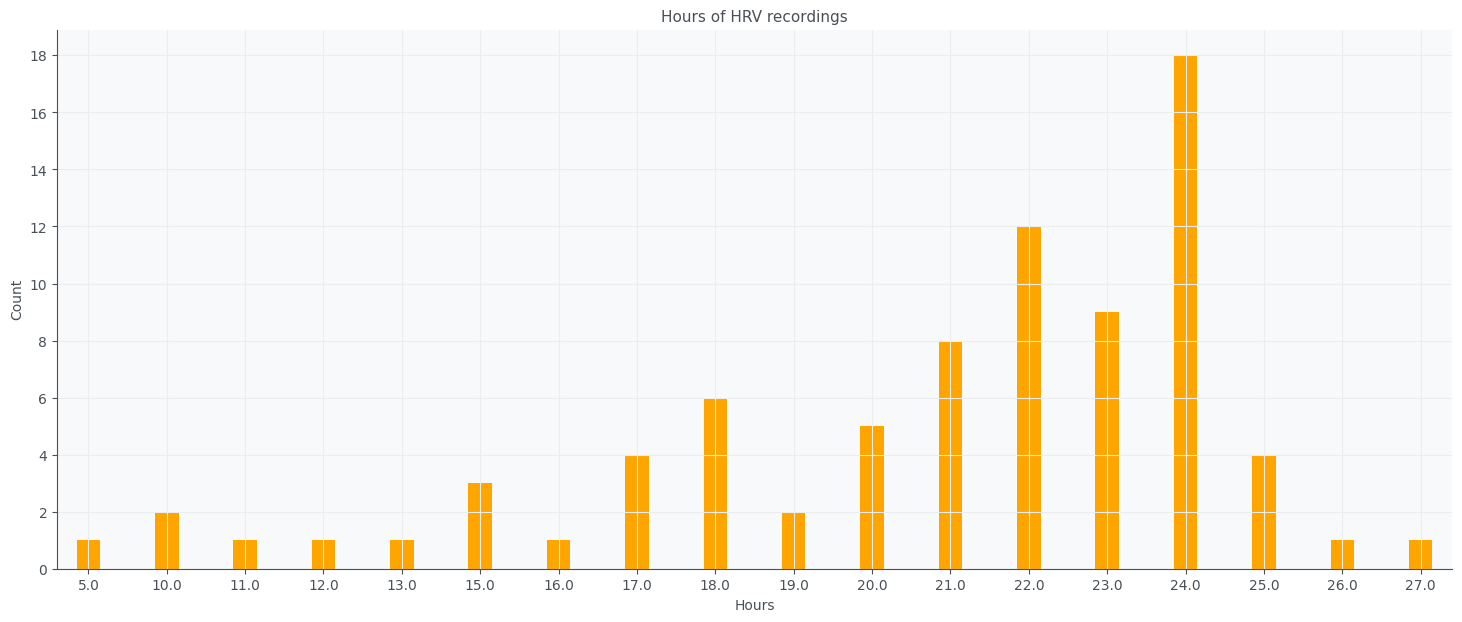

In [40]:
# Plot number of hours of HRV recordings

plt.figure(figsize=(18,7))
plt.title("Hours of HRV recordings")
plt.xlabel("Hours")
plt.ylabel("Count")
#plt.axis([5, 28, 0, 20])
plt.locator_params(axis="both", integer=True, nbins= 10)
HRV_DF.HRV_HOURS.value_counts().sort_index().plot(kind="bar", rot=0, width=0.3, color="orange")

plt.show()

In [41]:
# Preparing HRV for plots and analysis

#HRVdf = patient_info.dropna(subset = ['HRV_TIME', 'HRV_HOURS']) # Remove rows with NAs in those two columns.

#type(HRVdf)

#HRVdf.head()

Plotting HRV recording hours 

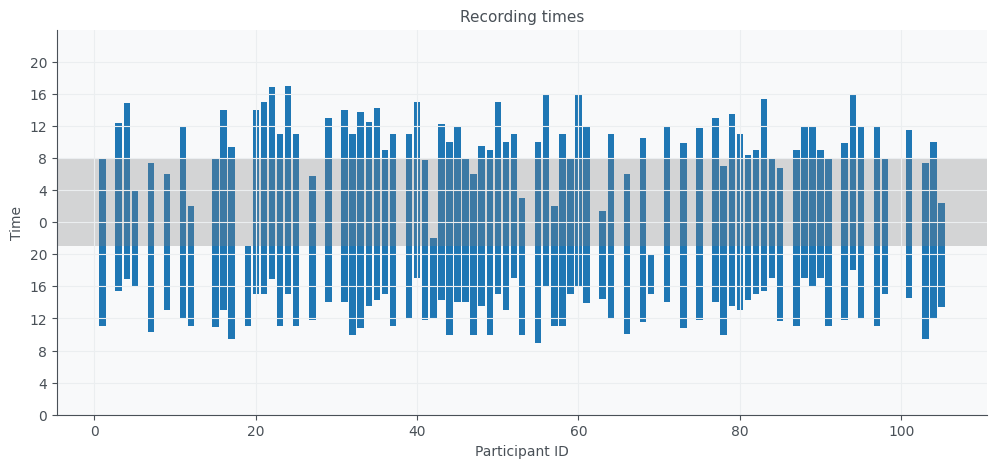

In [42]:
# Plotting HRV recording hours

ax = plt.bar(HRV_DF.ID, HRV_DF.HRV_HOURS, bottom=HRV_DF.HRV_TIME_float, label= "HRV recording hours")
plt.ylim(bottom=0, top=48)
plt.yticks(range(0, 48, 4), labels=list(range(0,24,4)) + list(range(0,24,4)))

plt.axhspan(21, 21+3+8, facecolor='grey', alpha=0.3)
plt.xlabel("Participant ID")
plt.ylabel("Time")
plt.title("Recording times")
plt.savefig('Recording_times.png')

plt.show()


Time domain analysis of HRV data

In [43]:
# Load HRV data

#HRV_1 = pd.read_csv("hyperaktiv/hrv_data/patient_hr_1.csv", sep=";")

# The code below is for setting Timestamp column as index
HRV_1 = pd.read_csv("hyperaktiv/hrv_data/patient_hr_1.csv", sep=";", parse_dates=['TIMESTAMP'], index_col=['TIMESTAMP'])

HRV_1.head()

,HRV
TIMESTAMP,
2009-03-04 11:00:00.000,2294.92
2009-03-04 11:00:02.295,631.84
2009-03-04 11:00:02.927,624.02
2009-03-04 11:00:03.551,636.72
2009-03-04 11:00:04.188,625.98


In [44]:
HRV_1.index

DatetimeIndex([       '2009-03-04 11:00:00', '2009-03-04 11:00:02.295000',
               '2009-03-04 11:00:02.927000', '2009-03-04 11:00:03.551000',
               '2009-03-04 11:00:04.188000', '2009-03-04 11:00:04.813000',
               '2009-03-04 11:00:05.446000', '2009-03-04 11:00:06.097000',
               '2009-03-04 11:00:06.753000', '2009-03-04 11:00:07.409000',
               ...
               '2009-03-05 08:07:27.530000', '2009-03-05 08:07:28.193000',
               '2009-03-05 08:07:28.864000', '2009-03-05 08:07:29.540000',
               '2009-03-05 08:07:30.230000', '2009-03-05 08:07:30.918000',
               '2009-03-05 08:07:31.590000', '2009-03-05 08:07:32.260000',
               '2009-03-05 08:07:32.931000', '2009-03-05 08:07:33.593000'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=107474, freq=None)

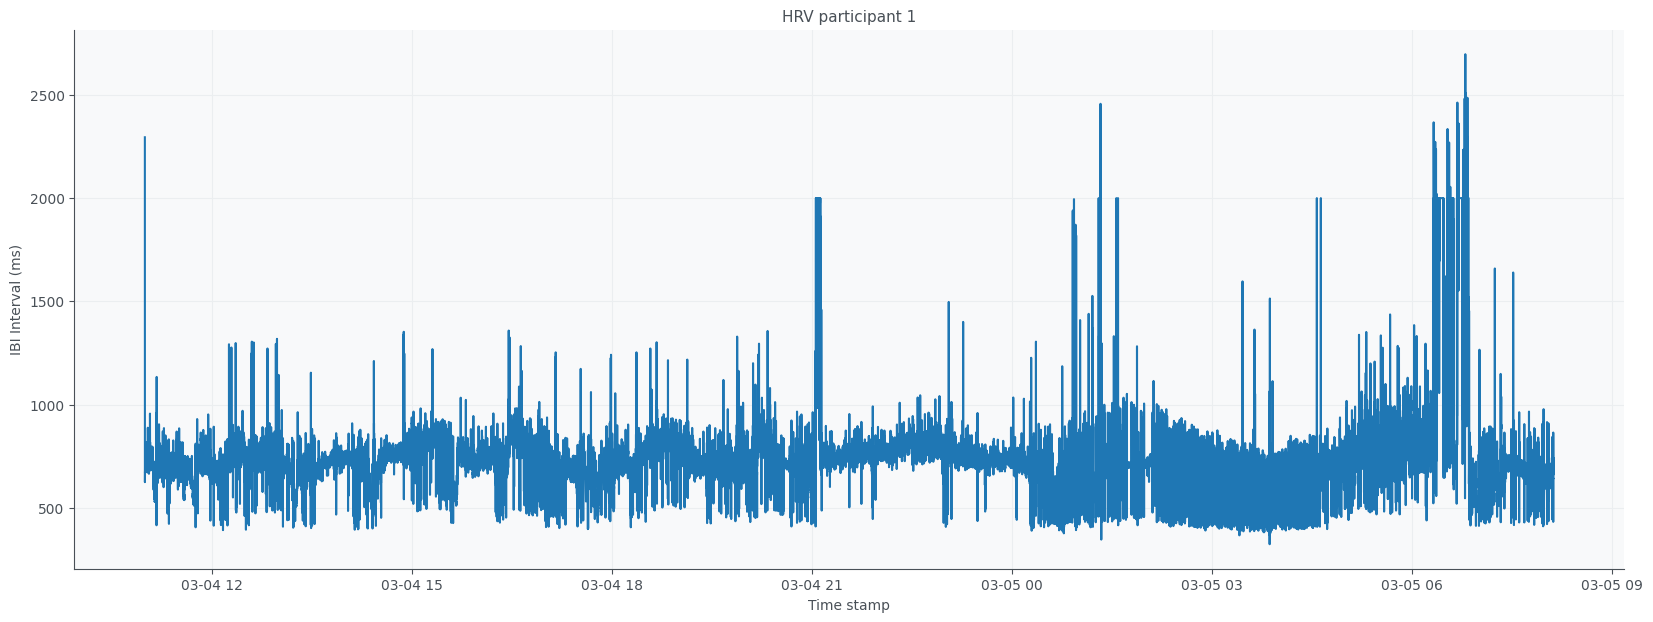

In [45]:
# Plot the HRV values and the timestamps.

plt.figure(figsize=(20, 7))
plt.title("HRV participant 1")
plt.xlabel("Time stamp")
plt.ylabel("IBI Interval (ms)")

plt.plot(HRV_1.HRV)
plt.show()

Dropping all data between 21:00 - 08:00


In [46]:
# Dropping all data between 21:00 - 08:00 for participant 1

HRV_1 = HRV_1[(HRV_1.index.hour >= 8) & (HRV_1.index.hour <= 20)]

print(HRV_1)

                             HRV
TIMESTAMP                       
2009-03-04 11:00:00.000  2294.92
2009-03-04 11:00:02.295   631.84
2009-03-04 11:00:02.927   624.02
2009-03-04 11:00:03.551   636.72
2009-03-04 11:00:04.188   625.98
...                          ...
2009-03-05 08:07:30.918   671.88
2009-03-05 08:07:31.590   669.92
2009-03-05 08:07:32.260   670.90
2009-03-05 08:07:32.931   662.11
2009-03-05 08:07:33.593   672.85

[51261 rows x 1 columns]


Replace outliers using interpolation - everything below 300ms and above 1300 ms

Trying for one participant first and plotting to see how well it worked.

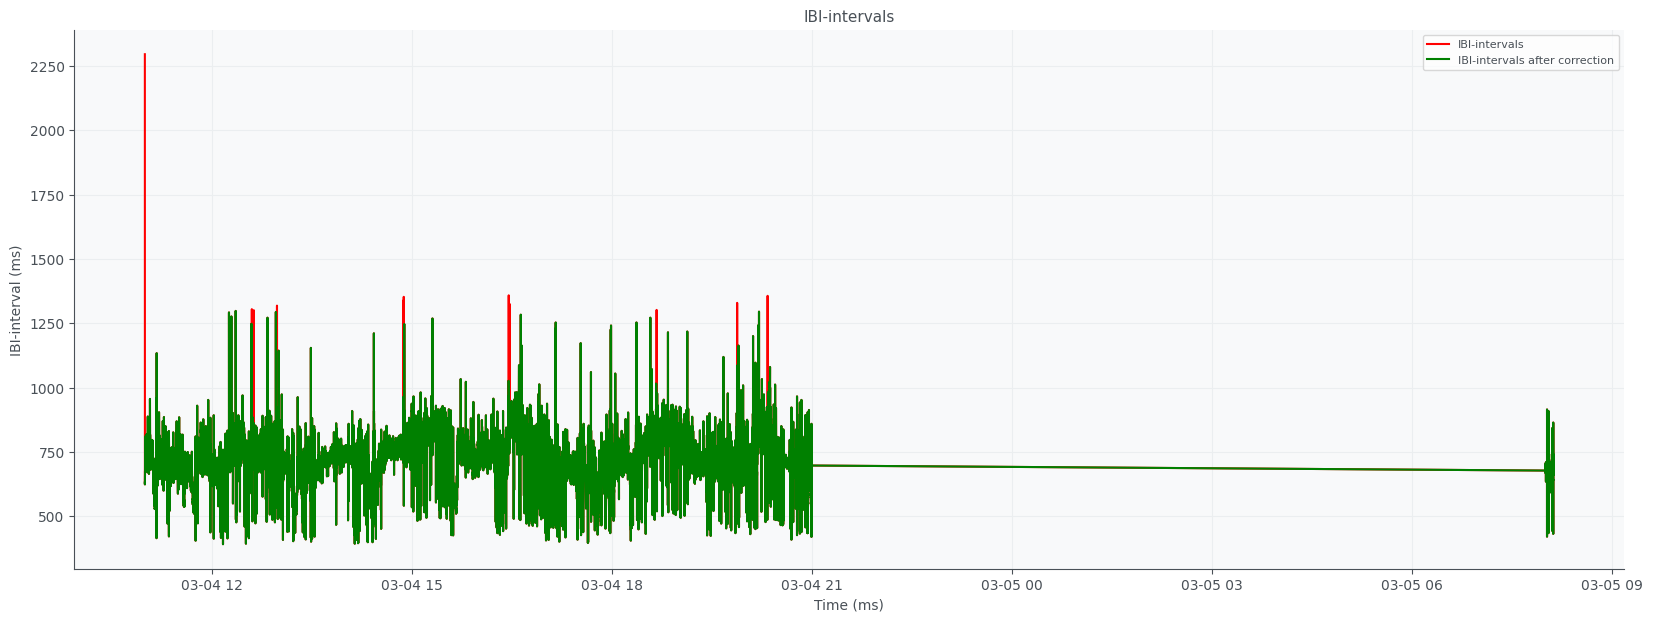

In [47]:
# For plotting, create a copy of the original HRV column and call it raw - it gets to keep the outliers
HRV_1_raw = HRV_1.HRV

# Turn every value below 300ms and above 1300ms to NaN
HRV_1['HRV'] = np.where((300 <= HRV_1['HRV']) & (HRV_1['HRV'] <= 1300), HRV_1['HRV'], np.nan)

# Fill NaN with interpolated value
HRV_1_cor = HRV_1['HRV'].interpolate(method='linear', axis=0).ffill().bfill()

plt.figure(figsize=(20, 7))

plt.title("IBI-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("IBI-interval (ms)")

plt.plot(HRV_1_raw, color="red", label="IBI-intervals")
plt.plot(HRV_1_cor, color="green",  label="IBI-intervals after correction")
plt.legend()
plt.show()

In [48]:
# Time domain analysis of Participant 1

def timedomain(HRV_1_cor):
    results = {}

    hr = 60000/HRV_1_cor #Divide number of miliseconds in a whole minute with the IBI to find how many beats occur in one minute (BPM)
    
    results['Mean IBI (ms)'] = np.mean(HRV_1_cor)
    results['SDNN (STD IBI) (ms)'] = np.std(HRV_1_cor)  # I want SDANN + SDNN index
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(HRV_1_cor)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(HRV_1_cor))))
    results['NN50'] = np.sum(np.abs(np.diff(HRV_1_cor)) > 50)*1  
    results['pNN50 (%)'] = 100 * np.sum((np.abs(np.diff(HRV_1_cor)) > 50)*1) / len(HRV_1_cor) 
    return results


print("Time domain metrics - IBI-intervals:")
for k, v in timedomain(HRV_1_cor).items():
    print("- %s: %.2f" % (k, v))


print(" ")


Time domain metrics - IBI-intervals:
- Mean IBI (ms): 711.03
- SDNN (STD IBI) (ms): 82.16
- Mean HR (Kubios' style) (beats/min): 84.38
- Mean HR (beats/min): 85.57
- STD HR (beats/min): 10.44
- Min HR (beats/min): 46.23
- Max HR (beats/min): 153.22
- RMSSD (ms): 44.49
- NN50: 2133.00
- pNN50 (%): 4.16
 


In [49]:
# Calculate SDANN and SDNN Index

# SDANN
SDANN = HRV_1.resample('5T').std()
SDANN


,HRV
TIMESTAMP,
2009-03-04 11:00:00,40.777937
2009-03-04 11:05:00,80.410900
2009-03-04 11:10:00,70.544131
2009-03-04 11:15:00,48.572720
2009-03-04 11:20:00,42.948152
...,...
2009-03-05 07:45:00,NaN
2009-03-05 07:50:00,NaN
2009-03-05 07:55:00,NaN


In [50]:
# SDNN Index
SDNNI = SDANN.HRV.mean()
SDNNI

50.44460778521849

Create a function for time domain analysis

In [51]:
def timedomain(x):
    results = {}

    hr = 60000/x.HRV #Divide number of miliseconds in a whole minute with the IBI to find how many beats occur in one minute (BPM)
    
    results['Mean IBI'] = round(np.mean(x.HRV), 3)
    results['SDNN'] = round(np.std(x.HRV), 3) 
    SDANN = x.resample('5T').std() # SDANN has a value for every 5min section, so I will not include it in the output
    results['SDNN Index'] = round(SDANN.HRV.mean(), 3)
    results['Mean HR'] = round(60000/np.mean(x.HRV), 3)
    results['STD HR'] = round(np.std(hr), 3)
    results['Min HR'] = round(np.min(hr), 3)
    results['Max HR'] = round(np.max(hr), 3)
    results['RMSSD'] = round(np.sqrt(np.mean(np.square(np.diff(x.HRV)))), 3)
    results['NN50'] = np.sum(np.abs(np.diff(x.HRV)) > 50)*1
    results['pNN50'] = round(100 * np.sum((np.abs(np.diff(x.HRV)) > 50)*1) / len(x.HRV), 3)
    return results



Create a loop that removes everything between 08:00 and 21:00, replaces outliers with interpolated values, and runs time domain analysis on every participant file

In [52]:
# Create a list object 
HRV_data = []
sdnni = []

# Create list of datafiles

data_files = glob.glob("hyperaktiv/hrv_data/*.csv")

# For every file in the hrv_data folder:
for file in data_files:
    data = pd.read_csv(file, sep = ";", parse_dates=['TIMESTAMP'], index_col=['TIMESTAMP'])
    data = data[(data.index.hour >= 8) & (data.index.hour <= 20)]
    data['HRV'] = np.where((300 <= data['HRV']) & (data['HRV'] <= 1300), data['HRV'], np.nan)
    data['HRV'] = data['HRV'].interpolate(method='linear', axis=0).ffill().bfill()
    results = timedomain(data)
    HRV_data.append(results)




# Convert list to dataframe
HRV_df = pd.DataFrame(HRV_data)
# Print head of the dataframe
    
HRV_df.head()


,Mean IBI,SDNN,SDNN Index,Mean HR,STD HR,Min HR,Max HR,RMSSD,NN50,pNN50
0,711.032,82.162,50.455,84.384,10.443,46.230,153.218,44.494,2133,4.161
1,759.993,220.028,84.446,78.948,26.338,46.161,199.481,86.854,10657,21.935
2,634.521,125.293,56.302,94.560,17.988,46.195,198.834,47.913,2936,4.561
3,663.711,101.498,56.757,90.401,12.656,46.475,199.481,35.514,4202,6.917
4,596.728,95.721,43.125,100.548,15.360,46.161,199.481,45.602,1159,2.565


In [53]:
extract = HRV_DF[["ADHD", "AGE", "SEX", "HRV_HOURS"]]

extract = extract.reset_index(drop=True)
print(extract)

    ADHD  AGE  SEX  HRV_HOURS
0      1    3    0       21.0
1      1    2    1       21.0
2      1    3    1       22.0
3      1    1    1       12.0
4      0    3    0       21.0
..   ...  ...  ...        ...
75     1    3    0       17.0
76     0    1    1       21.0
77     0    4    1       22.0
78     0    2    0       22.0
79     0    4    1       13.0

[80 rows x 4 columns]


In [54]:
HRV_df = extract.join(HRV_df)

print(HRV_df)

    ADHD  AGE  SEX  HRV_HOURS  Mean IBI     SDNN  SDNN Index  Mean HR  STD HR  \
0      1    3    0       21.0   711.032   82.162      50.455   84.384  10.443   
1      1    2    1       21.0   759.993  220.028      84.446   78.948  26.338   
2      1    3    1       22.0   634.521  125.293      56.302   94.560  17.988   
3      1    1    1       12.0   663.711  101.498      56.757   90.401  12.656   
4      0    3    0       21.0   596.728   95.721      43.125  100.548  15.360   
..   ...  ...  ...        ...       ...      ...         ...      ...     ...   
75     1    3    0       17.0   646.780  118.448      67.822   92.767  18.337   
76     0    1    1       21.0   652.370  112.581      65.975   91.972  15.126   
77     0    4    1       22.0   696.243   97.593      54.397   86.177  12.553   
78     0    2    0       22.0   865.000  130.559      72.733   69.364  12.130   
79     0    4    1       13.0   634.715  144.764      91.009   94.531  20.374   

    Min HR   Max HR    RMSS

Visualize and compare the groups

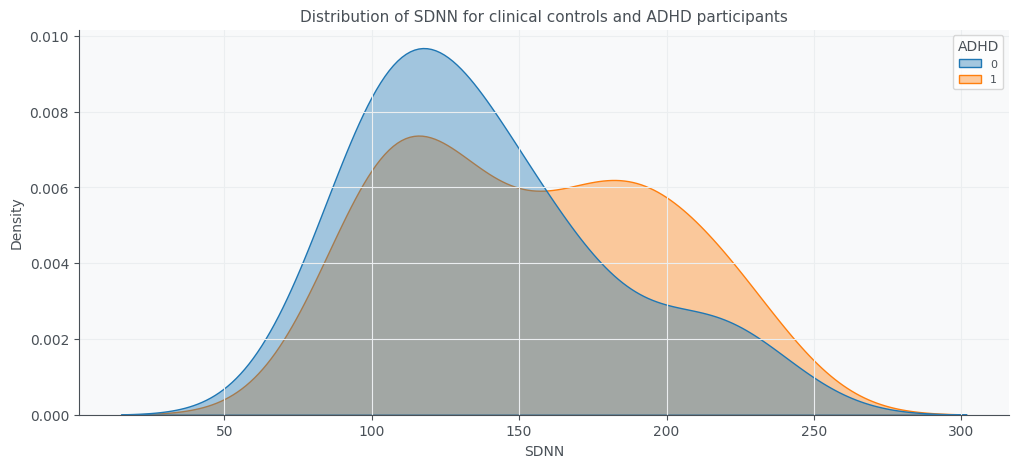

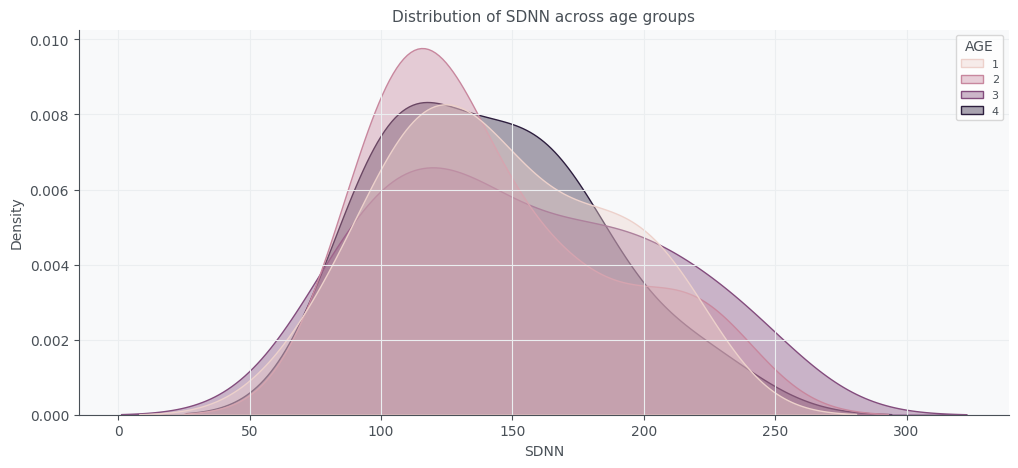

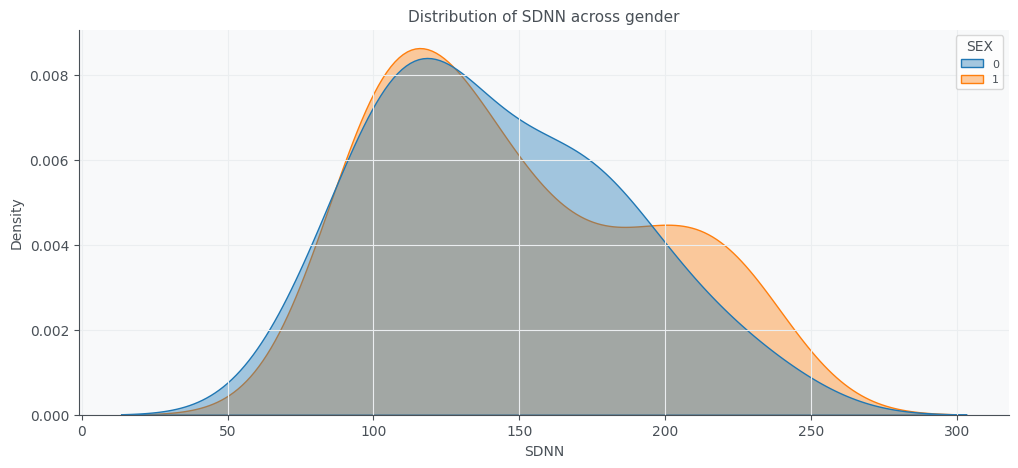

In [55]:
# Density plot 

# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,5


# ADHD vs clinical control
sns.kdeplot(data=HRV_df, x="SDNN", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN for clinical controls and ADHD participants')
plt.show()

# Different age groups
sns.kdeplot(data=HRV_df, x="SDNN", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across age groups')
plt.show()

# Gender 
sns.kdeplot(data=HRV_df, x="SDNN", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across gender')
plt.show()



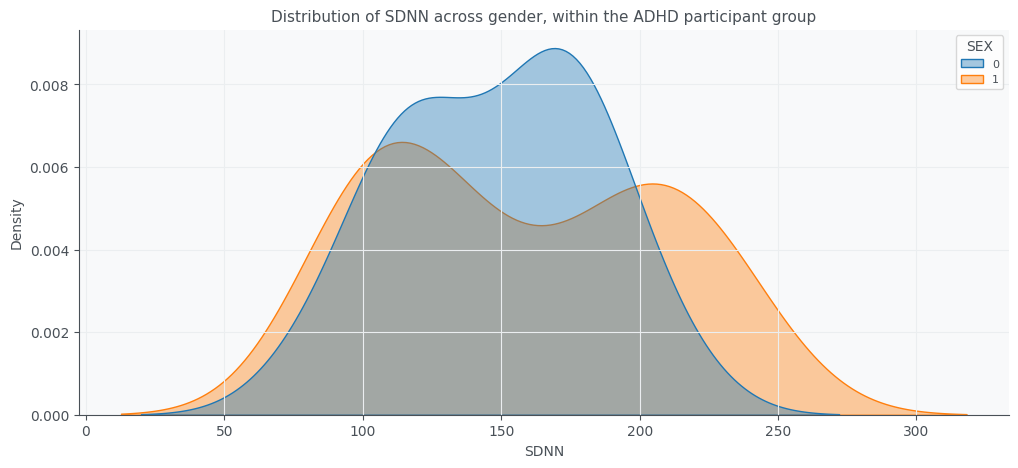

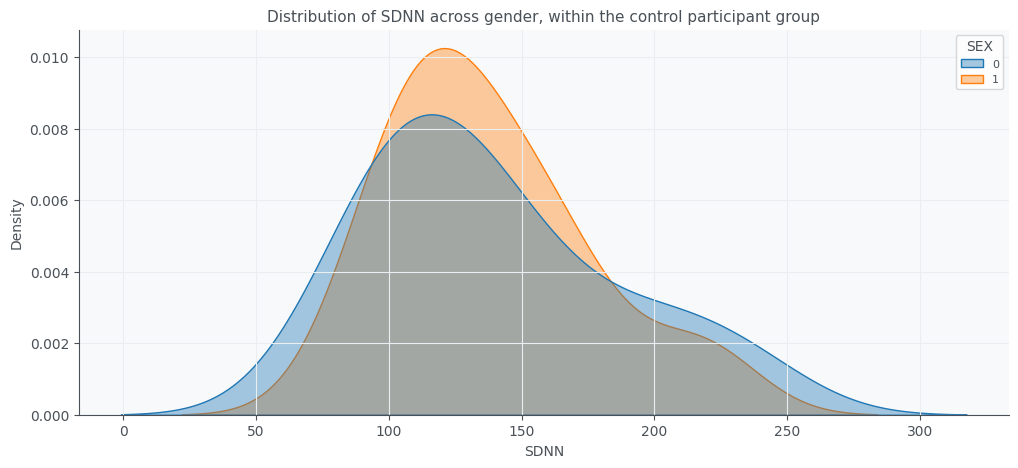

In [56]:
# ADHD participants seem to have a bimodal distribution. 

# Differences in gender on only adhd participant
adhd = HRV_df.loc[(HRV_df['ADHD']== 1)]

sns.kdeplot(data=adhd, x="SDNN", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across gender, within the ADHD participant group')
plt.show()


# Differences in gender on only clinical controls
control = HRV_df.loc[(HRV_df['ADHD']== 0)]

sns.kdeplot(data=control, x="SDNN", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across gender, within the control participant group')
plt.show()




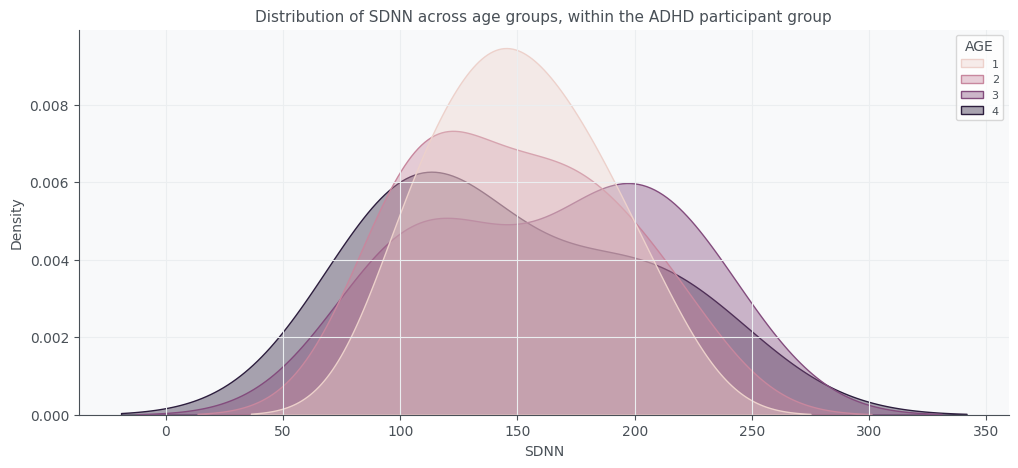

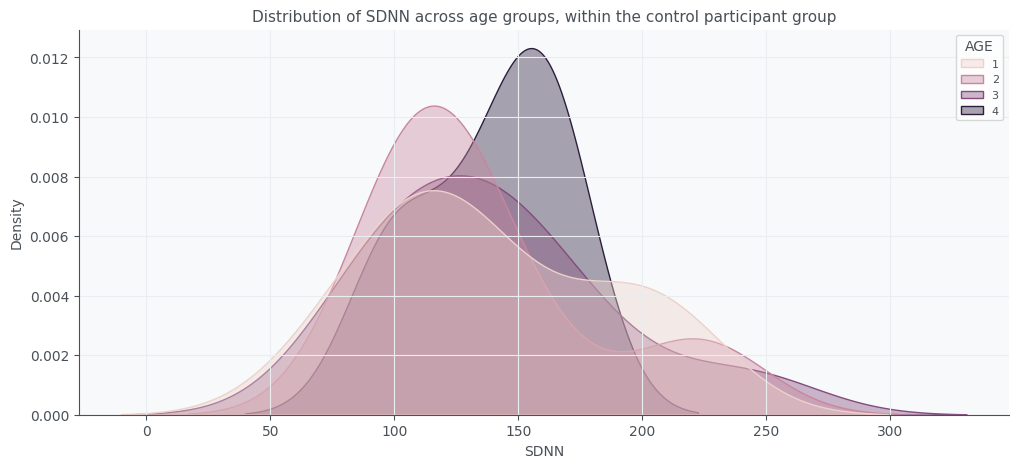

In [57]:
# ADHD - age groups 
sns.kdeplot(data=adhd, x="SDNN", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across age groups, within the ADHD participant group')
plt.show()

# Control - age groups
sns.kdeplot(data=control, x="SDNN", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across age groups, within the control participant group')
plt.show()

Making some scatterplots to investigate the bimodality of some of the plots

<AxesSubplot: xlabel='SDNN', ylabel='HRV_HOURS'>

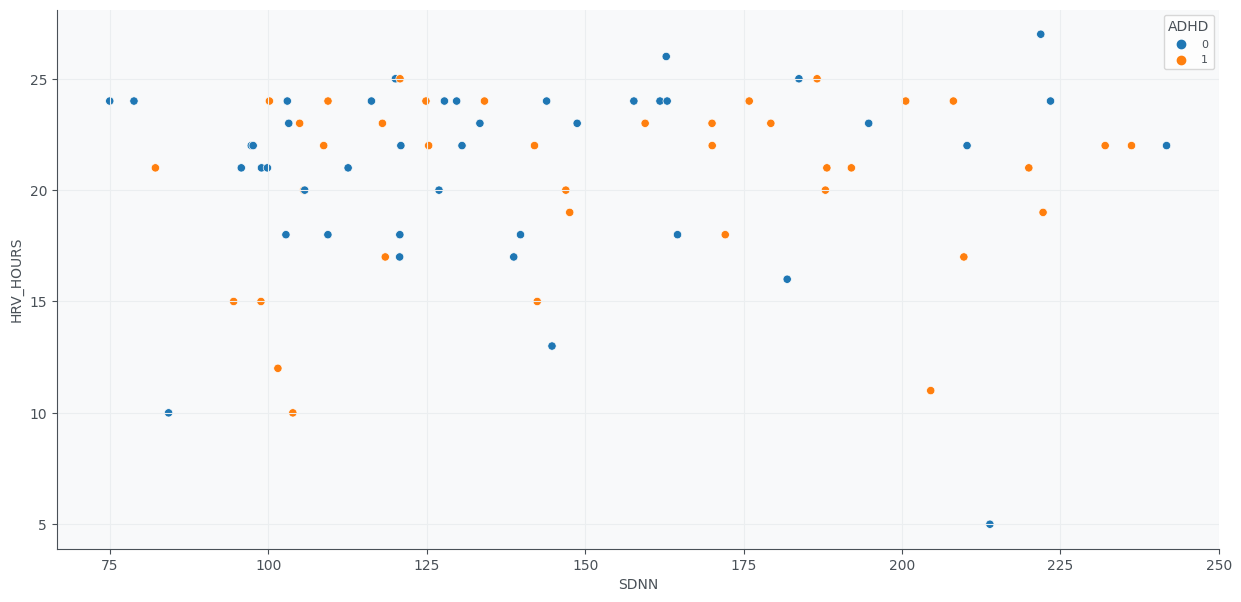

In [58]:
# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=HRV_df['SDNN'], y=HRV_df['HRV_HOURS'], hue=HRV_df['ADHD'], legend='full', ax=ax)


<AxesSubplot: xlabel='SDNN', ylabel='HRV_HOURS'>

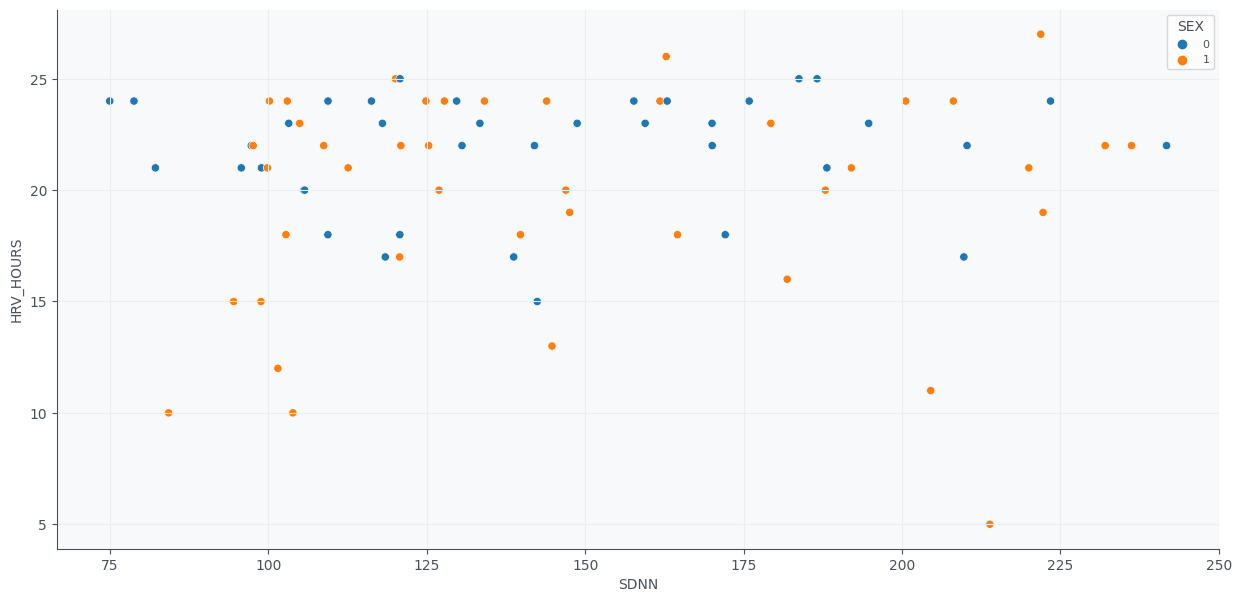

In [59]:
# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=HRV_df['SDNN'], y=HRV_df['HRV_HOURS'], hue=HRV_df['SEX'], legend='full', ax=ax)

<AxesSubplot: xlabel='SDNN', ylabel='HRV_HOURS'>

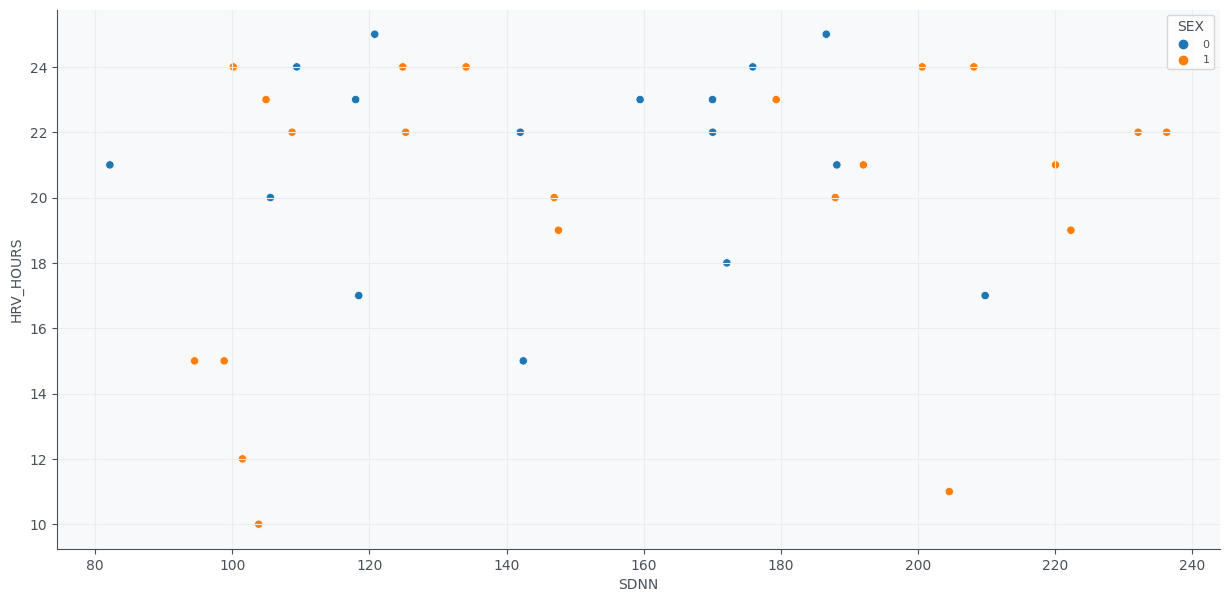

In [60]:
# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=adhd['SDNN'], y=adhd['HRV_HOURS'], hue=adhd['SEX'], legend='full', ax=ax)

<AxesSubplot: xlabel='SDNN', ylabel='HRV_HOURS'>

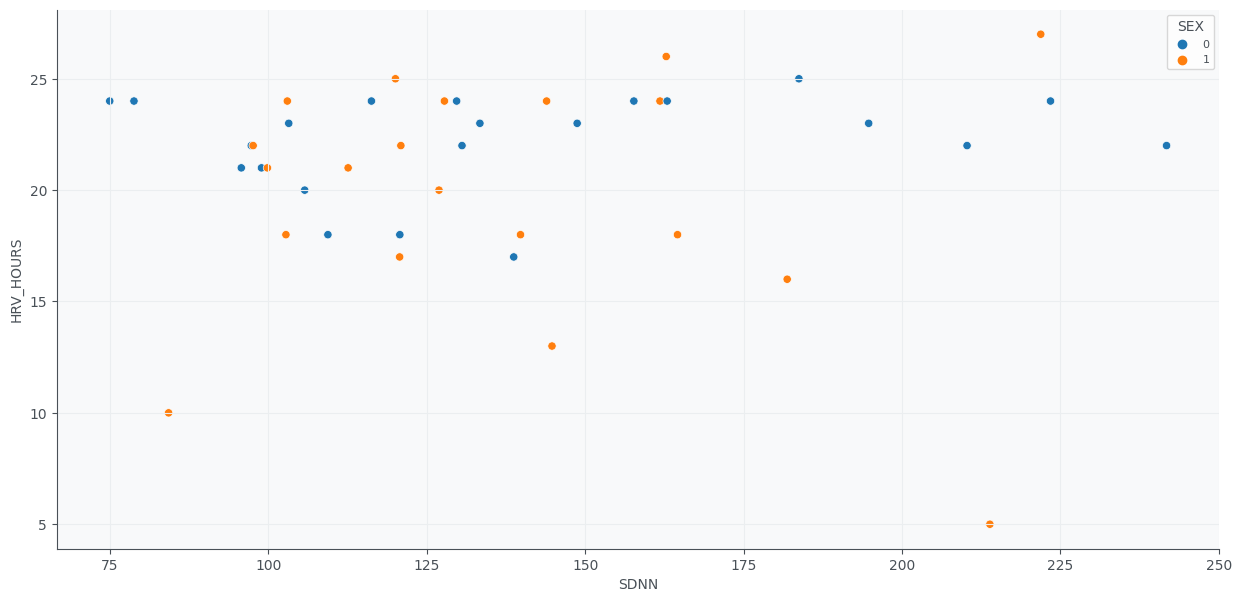

In [61]:
# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=control['SDNN'], y=control['HRV_HOURS'], hue=control['SEX'], legend='full', ax=ax)


Text(0.5, 1.0, 'ANXIETY')

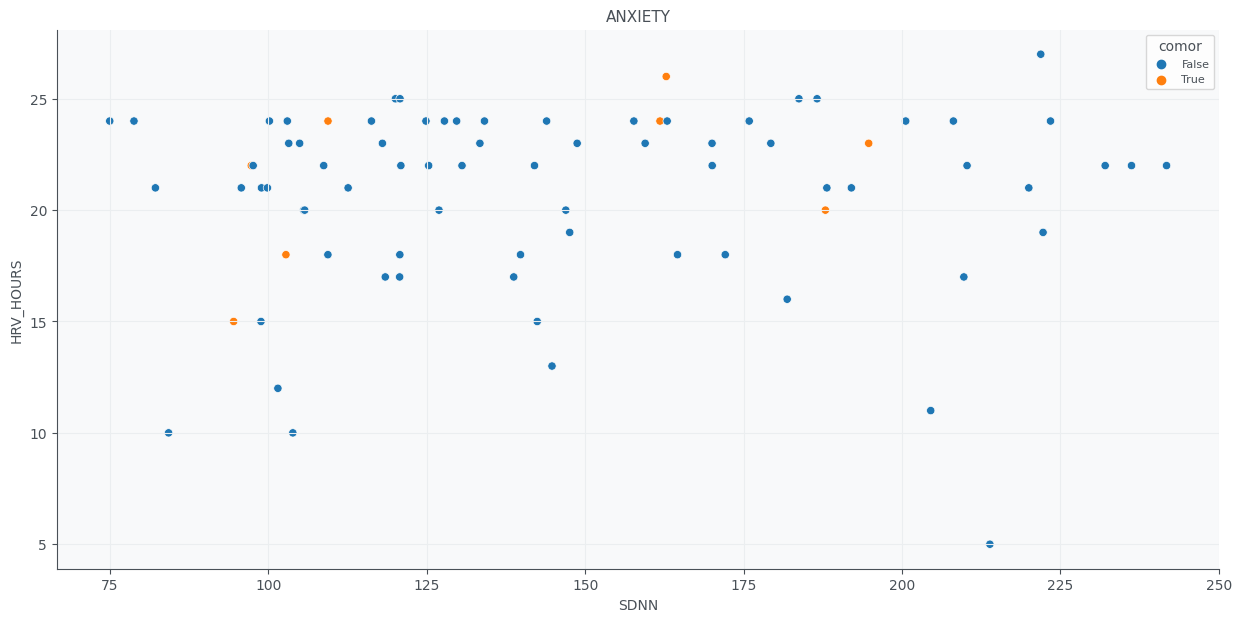

In [81]:
# Try to plot comorbidities.
patient_info = patient_info[patient_info['HRV']==1]
patient_info = patient_info[["ID", "SEX", "AGE", "ADHD", "HRV", "HRV_TIME", "HRV_HOURS", "ADD", "BIPOLAR", "UNIPOLAR", "ANXIETY"]]

conditions = [
    (patient_info["ADD"] == 1),
    (patient_info["BIPOLAR"] == 1),
    (patient_info["UNIPOLAR"] == 1),
    (patient_info["ANXIETY"] == 1)
]

co = ["ADD", "BIPOLAR", "UNIPOLAR", "ANXIETY"]

HRV_df["comor"] = np.select(conditions, co)

# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=HRV_df['SDNN'], y=HRV_df['HRV_HOURS'], hue=HRV_df['comor']== "ANXIETY", legend='full', ax=ax)
plt.title("ANXIETY")


Checking assumptions of homogeneity of variance before running t-tests.

Levene's test: 
If p-value is less than 0.05, we reject the null hypothesis, that Group 1 and Group 2 come from populations with equal variances.
If p-value is larger than 0.05, we do not reject the null hypothesis, that Group 1 and Group 2 come from populations with equal variances.

In [ ]:
# Subset data
# ADHD - male vs female *
adhd_m = HRV_df.loc[(HRV_df['ADHD']== 1) & (HRV_df['SEX']== 1)]
adhd_f = HRV_df.loc[(HRV_df['ADHD']== 1) & (HRV_df['SEX']== 0)]

# Control - male vs female *
control_m = HRV_df.loc[(HRV_df['ADHD']== 0) & (HRV_df['SEX']== 1)]
control_f = HRV_df.loc[(HRV_df['ADHD']== 0) & (HRV_df['SEX']== 0)]

# All male vs female (regardless of participant group) *
male = HRV_df.loc[(HRV_df['SEX']== 1)]
female = HRV_df.loc[(HRV_df['SEX']== 0)]

# All Age groups *
age1 = HRV_df.loc[(HRV_df['AGE']== 1)]
age2 = HRV_df.loc[(HRV_df['AGE']== 2)]
age3 = HRV_df.loc[(HRV_df['AGE']== 3)]
age4 = HRV_df.loc[(HRV_df['AGE']== 4)]

# ADHD - age groups *
adhdage1 = HRV_df.loc[(HRV_df['AGE']== 1)&(HRV_df['ADHD']== 1)]
adhdage2 = HRV_df.loc[(HRV_df['AGE']== 2)&(HRV_df['ADHD']== 1)]
adhdage3 = HRV_df.loc[(HRV_df['AGE']== 3)&(HRV_df['ADHD']== 1)]
adhdage4 = HRV_df.loc[(HRV_df['AGE']== 4)&(HRV_df['ADHD']== 1)]

# Control - age groups *
controlage1 = HRV_df.loc[(HRV_df['AGE']== 1)&(HRV_df['ADHD']== 0)]
controlage2 = HRV_df.loc[(HRV_df['AGE']== 2)&(HRV_df['ADHD']== 0)]
controlage3 = HRV_df.loc[(HRV_df['AGE']== 3)&(HRV_df['ADHD']== 0)]
controlage4 = HRV_df.loc[(HRV_df['AGE']== 4)&(HRV_df['ADHD']== 0)]

In [85]:
# Define a function that runs Levene's test for the last 10 columns in the dataframe

def lev(x, y, *args):
    test_results = {}

    test_results['Mean IBI'] = levene(x['Mean IBI'], y['Mean IBI'])
    test_results['SDNN'] = levene(x['SDNN'], y['SDNN'])
    test_results['SDNN Index'] = levene(x['SDNN Index'], y['SDNN Index'])
    test_results['Mean HR'] = levene(x['Mean HR'], y['Mean HR'])
    test_results['STD HR'] = levene(x['STD HR'], y['STD HR'])
    test_results['Min HR'] = levene(x['Min HR'], y['Min HR'])
    test_results['Max HR'] = levene(x['Max HR'], y['Max HR'])
    test_results['RMSSD'] = levene(x['RMSSD'], y['RMSSD'])
    test_results['NN50'] = levene(x['NN50'], y['NN50'])
    test_results['pNN50'] = levene(x['pNN50'], y['pNN50'])

    test_results = pd.DataFrame.from_dict(test_results)
    test_results.index = ["statistic", "P-value"]
    return test_results


# Define a function where 


In [87]:
aa = lev(adhd, control)
bb = lev(adhd_m, adhd_f)
cc = lev(control_m, control_f)
dd = lev(male, female)
ee = lev(age1, age2, age3, age4)
ff = lev(adhdage1, adhdage2, adhdage3, adhdage4)
gg = lev(controlage1, controlage2, controlage3, controlage4)

print(aa)
print(bb)
print(cc)
print(dd)
print(ee)
print(ff)
print(gg)


           Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
statistic  0.390977  1.208588    1.819228  0.087964  1.810781  0.352093   
P-value    0.533611  0.274993    0.181308  0.767570  0.182313  0.554648   

             Max HR     RMSSD      NN50     pNN50  
statistic  0.975029  1.896253  0.350756  0.998622  
P-value    0.326482  0.172438  0.555398  0.320734  
           Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
statistic  0.131803  3.970917    0.505335  0.331100  0.147030  0.121822   
P-value    0.718693  0.053916    0.481746  0.568591  0.703645  0.729100   

             Max HR     RMSSD      NN50     pNN50  
statistic  1.821049  2.375437  1.958340  1.265391  
P-value    0.185614  0.132002  0.170249  0.268078  
           Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
statistic  0.087941  0.730728    1.182470  0.009781  1.445755  0.504490   
P-value    0.768346  0.397739    0.283363  0.921712  0.236280  0.481655   

          

All p-values are above 0.05, thus we do not reject the null hypothesis, that Group 1 and Group 2 come from populations with equal variances.
We can now move on to T-tests.

T-Tests to see whether there are significant differences between groups

In [64]:
# Define a function that runs T-test for the last 10 columns in the dataframe

def ttest(x, y):
    test_results = {}

    test_results['Mean IBI'] = stats.ttest_ind(x['Mean IBI'], y['Mean IBI'], equal_var=True)
    test_results['SDNN'] = stats.ttest_ind(x['SDNN'], y['SDNN'], equal_var=True)
    test_results['SDNN Index'] = stats.ttest_ind(x['SDNN Index'], y['SDNN Index'], equal_var=True)
    test_results['Mean HR'] = stats.ttest_ind(x['Mean HR'], y['Mean HR'], equal_var=True)
    test_results['STD HR'] = stats.ttest_ind(x['STD HR'], y['STD HR'], equal_var=True)
    test_results['Min HR'] = stats.ttest_ind(x['Min HR'], y['Min HR'], equal_var=True)
    test_results['Max HR'] = stats.ttest_ind(x['Max HR'], y['Max HR'], equal_var=True)
    test_results['RMSSD'] = stats.ttest_ind(x['RMSSD'], y['RMSSD'], equal_var=True)
    test_results['NN50'] = stats.ttest_ind(x['NN50'], y['NN50'], equal_var=True)
    test_results['pNN50'] = stats.ttest_ind(x['pNN50'], y['pNN50'], equal_var=True)

    test_results = pd.DataFrame.from_dict(test_results)
    test_results.index = ["T-score", "P-value"]
    return test_results



In [65]:
# T-test
a = ttest(adhd, control) # main hypothesis
b = ttest(control_m, control_f) # sanity check
c = ttest(adhd_m, adhd_f)
d = ttest(adhd_m, control_m)
e = ttest(adhd_f, control_f)

print(a)
print(b)
print(c)
print(d)
print(e)

         Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
T-score -0.853708  1.595443    1.258361  0.814522  1.648894 -0.436448   
P-value  0.395881  0.114657    0.212015  0.417826  0.103192  0.663717   

           Max HR     RMSSD      NN50     pNN50  
T-score  0.976115  0.802906  0.207976  0.449052  
P-value  0.332025  0.424469  0.835790  0.654639  
         Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
T-score  1.096413 -0.102683    1.141339 -0.992223 -0.874466  0.636376   
P-value  0.279455  0.918728    0.260516  0.327053  0.387085  0.528156   

           Max HR     RMSSD      NN50     pNN50  
T-score -2.170063  0.155879  0.202409  0.621116  
P-value  0.035998  0.876912  0.840623  0.538047  
         Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
T-score -0.816530  0.657128    0.184971  0.896888  0.238581  0.220997   
P-value  0.419568  0.515278    0.854290  0.375737  0.812783  0.826344   

           Max HR     RMSSD      NN50   

In [66]:
# REMOVE THIS - this is just for checking that the outputs are correct when my self-made function is not used.

# ADHD vs controls *
print(stats.ttest_ind(a=adhd['SDNN'], b=control['SDNN'], equal_var=True))

# All male vs female (regardless of participant group) *
print(stats.ttest_ind(a=male['SDNN'], b=female['SDNN'], equal_var=True))

# ADHD - male vs female *
print(stats.ttest_ind(a=adhd_m['SDNN'], b=adhd_f['SDNN'], equal_var=True))

# Control - male vs female *
print(stats.ttest_ind(a=control_m['SDNN'], b=control_f['SDNN'], equal_var=True))


Ttest_indResult(statistic=1.5954433414984885, pvalue=0.11465720923672074)
Ttest_indResult(statistic=0.5480900079233427, pvalue=0.5851953115291224)
Ttest_indResult(statistic=0.6571283516458836, pvalue=0.5152778719945645)
Ttest_indResult(statistic=-0.10268298438649538, pvalue=0.9187276446464785)


In [68]:
# All Age groups * - one-way ANOVA (testing the relationship between -timedomain metric- and age group)
# Subset columns I want to run anova on
age1s = age1[""]

f_oneway(age1, age2, age3, age4)

# ADHD - age groups * - two-way ANOVA (testing the relationship between -timedomain metric-, age group, and participant group)

# Control - age groups * - same as above


ValueError: could not convert string to float: 'ADD'

Frequency domain analysis

In [45]:
# Removing the first entry/row in the dataset because it is a very large value and it interferes with interpolation (outlier?)
# IBI_1 = IBI.drop(index=0)

# IBI_1.head()

NameError: name 'IBI' is not defined

In [ ]:
# Frequency domain analysis of Participant 1

# Fourier Transformation requires evenly sampled data, and the time between each timestamp in the dataset is currently
# not even. This can be done by interpolating the data.

# Creating an interpolation function. We want 4 samples per second.
x = np.cumsum(IBI_1)/1000.0   # This turns ms to sec.
f = interp1d(x, IBI_1, kind= "cubic")

# Sample rate for interpolation and stepsize
fs = 4.0
steps = 1/fs

# Sampling from interpolation function
xx = np.arange(1, np.max(x), steps)
IBI_interpolated = f(xx)


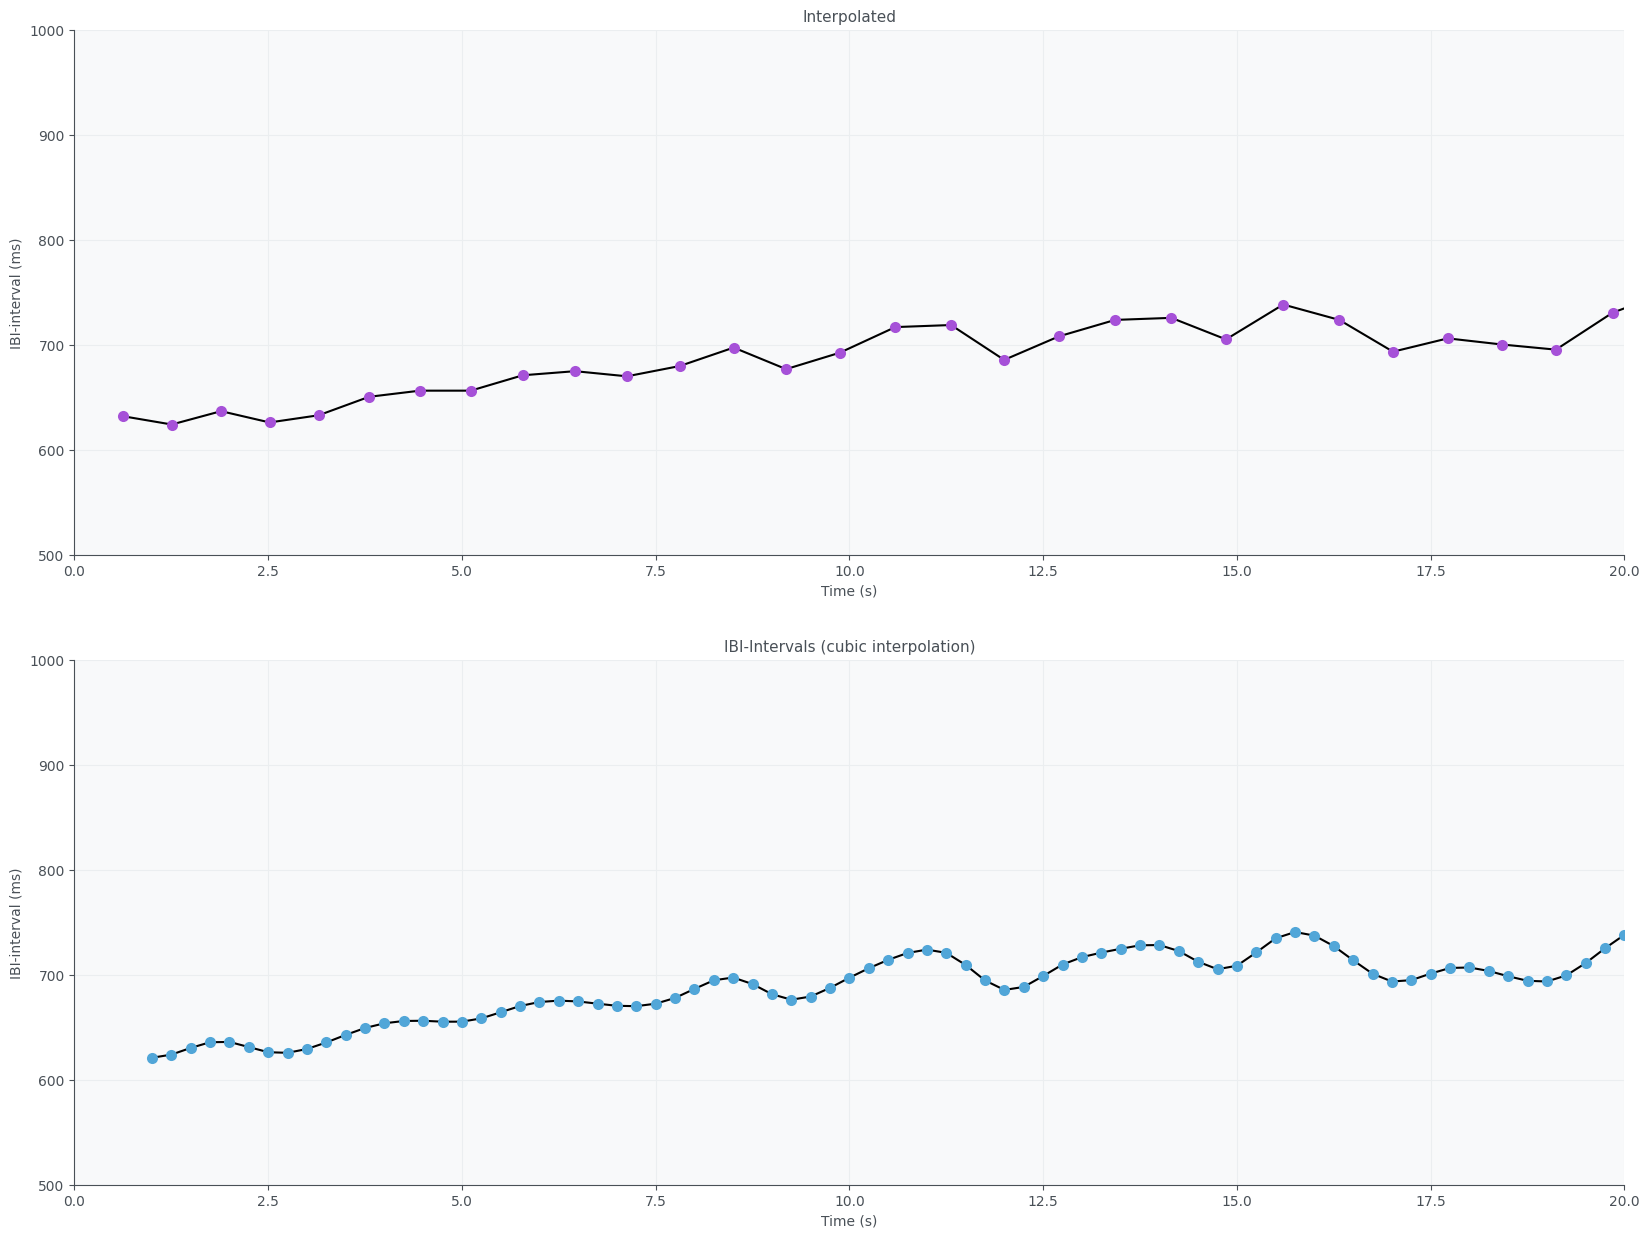

In [ ]:
# Plot to see the interpolation
plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("IBI intervals")
plt.plot(x, IBI_1, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("IBI-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 20)
plt.gca().set_ylim(500, 1000)

plt.subplot(212)
plt.title("IBI-Intervals (cubic interpolation)")
plt.plot(xx, IBI_interpolated, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 20)
plt.gca().set_ylim(500, 1000)
plt.xlabel("Time (s)")
plt.ylabel("IBI-interval (ms)")
plt.show()

In [ ]:
##### THIS SNIPPET IS ALSMOST ENTIRELY STOLEN, SHOULD I MAKE CHANGES IN IT?

def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=IBI_interpolated, fs=fs)
    
    '''
    Segment found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)  # Conditions for the different frequency bands
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)

  # calculate the power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum to get the total power
    total_power = vlf + lf + hf


     # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx


In [ ]:
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(IBI_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 1187.25
- Power LF (ms2): 1464.41
- Power HF (ms2): 1704.66
- Power Total (ms2): 4356.33
- LF/HF: 0.86
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.05
- Peak HF (Hz): 0.20
- Fraction LF (nu): 46.21
- Fraction HF (nu): 53.79


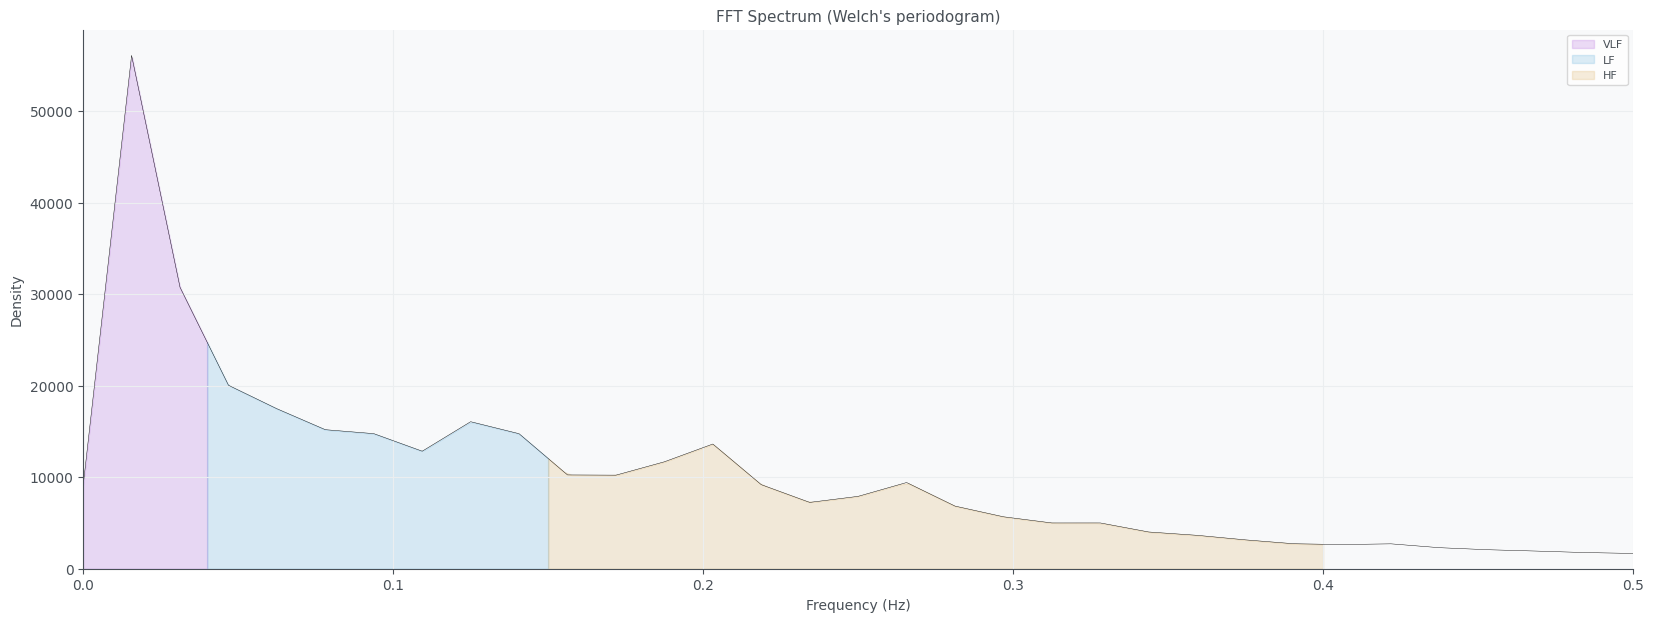

In [ ]:
# Plot Welch periodogram

plt.figure(figsize=(20, 7))
plt.plot(fxx, pxx, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

Non-linear Methods - Poincaré plot

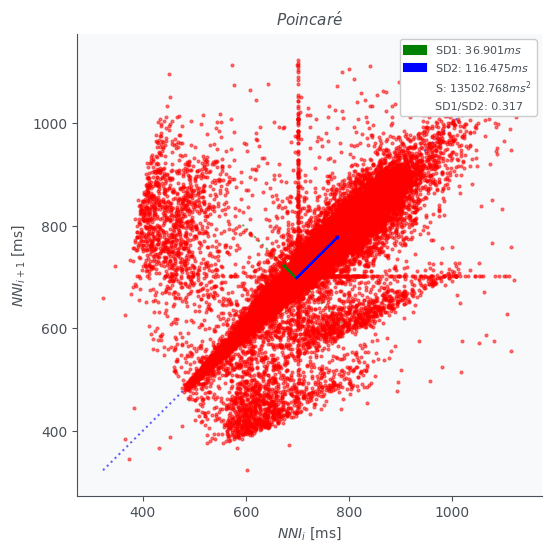

ReturnTuple(poincare_plot=<Figure size 600x600 with 1 Axes>, sd1=36.901141784077424, sd2=116.47511187830169, sd_ratio=3.156409429275705, ellipse_area=13502.768227738325)

In [ ]:
# Trying the pyHRV package

nonlinear.poincare(IBI_corrected, ellipse=True)

Activity data

In [ ]:
# Load activity data

ACT_1 = pd.read_csv("hyperaktiv/activity_data/patient_activity_01.csv", sep= ";")

ACT_1.head()

,TIMESTAMP,ACTIVITY
0,02-23-2009 16:00,0
1,02-23-2009 16:01,195
2,02-23-2009 16:02,240
3,02-23-2009 16:03,209
4,02-23-2009 16:04,202
